In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib import style
style.use('seaborn-white')

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
#assert pyro.__version__.startswith('1.8.2')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [3]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
mu_c = 0.0005
mu_p = 0.000002
gravity = 9.8 
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = -0.2+0.5*np.sin(6*ts[i])
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

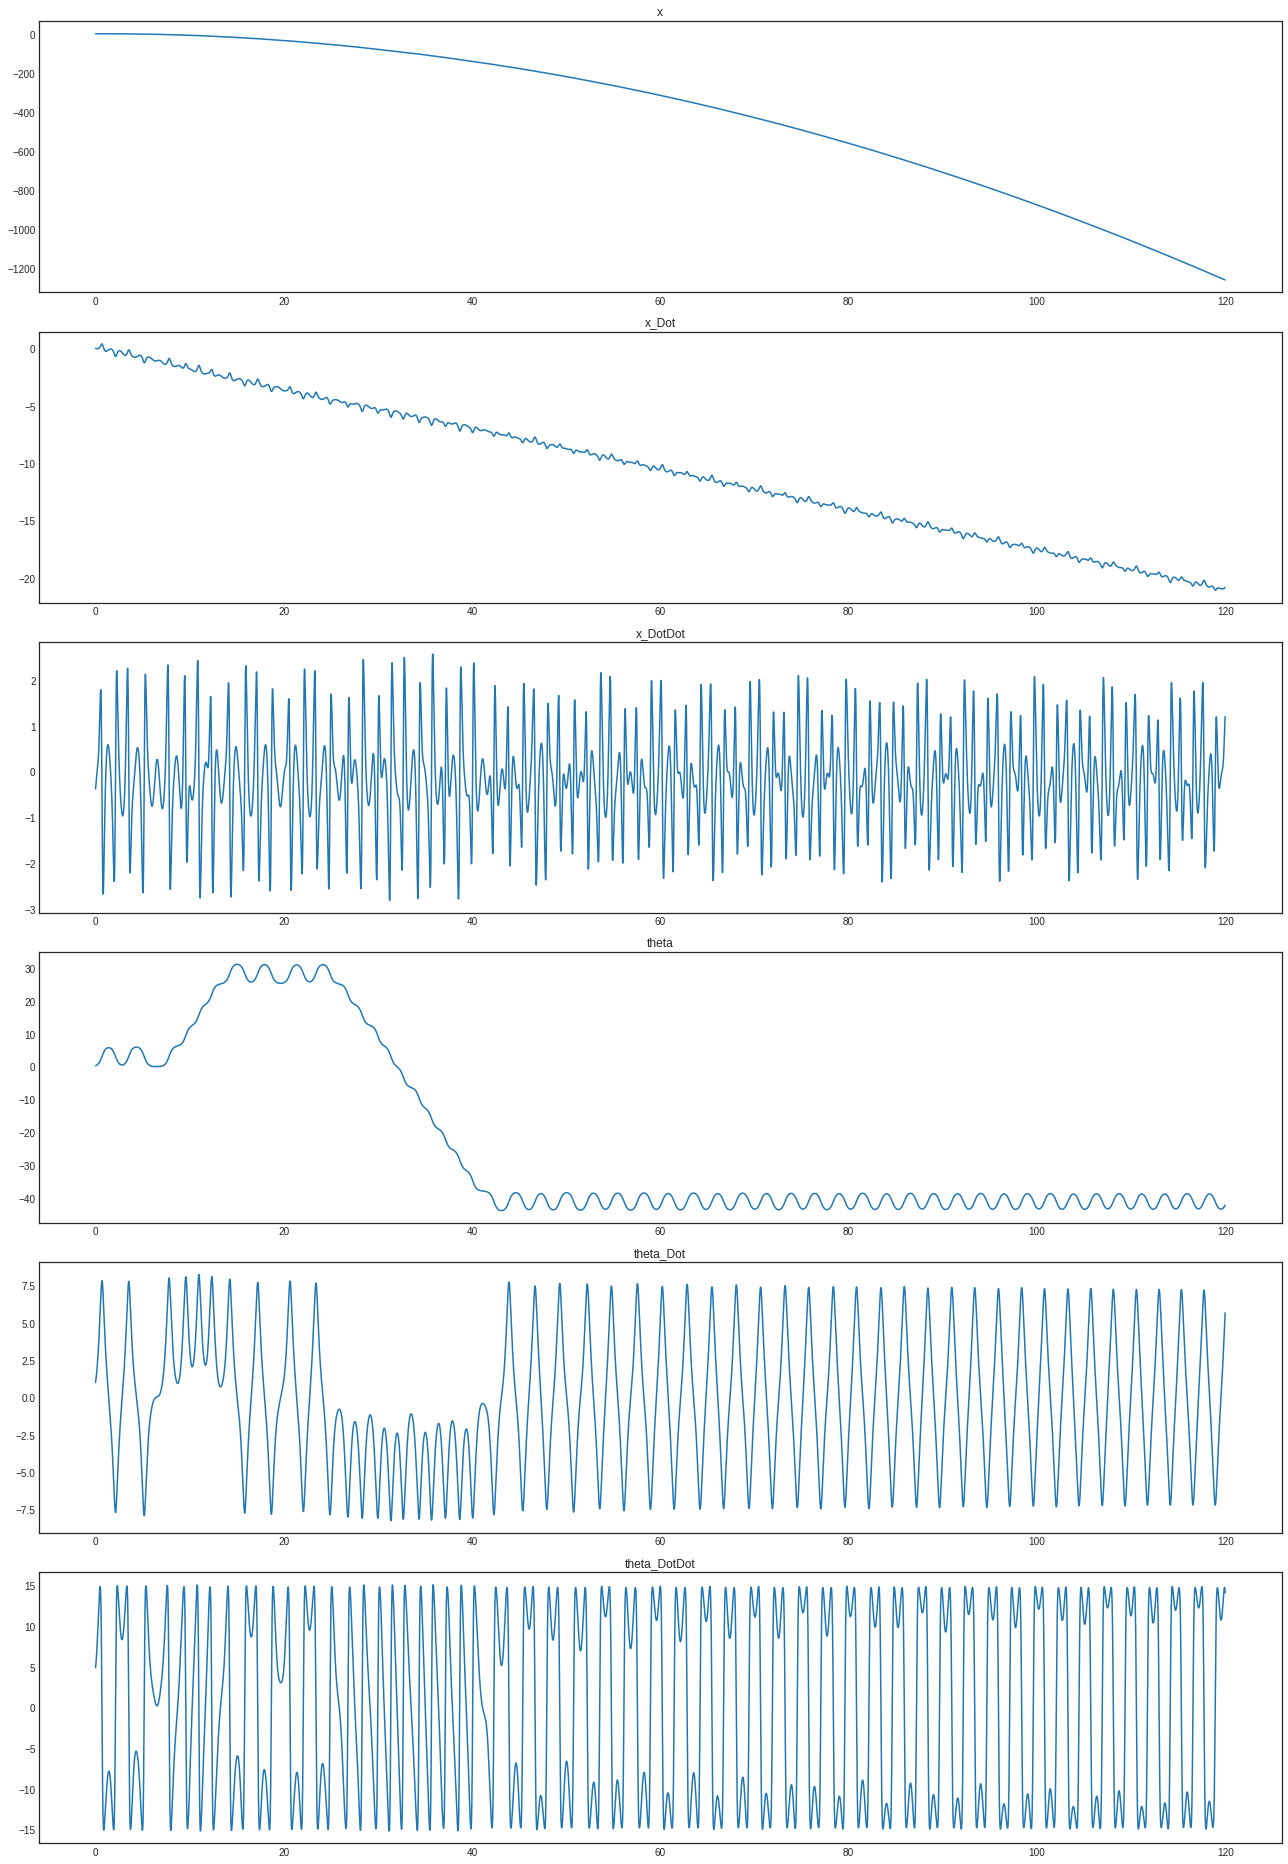

In [4]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

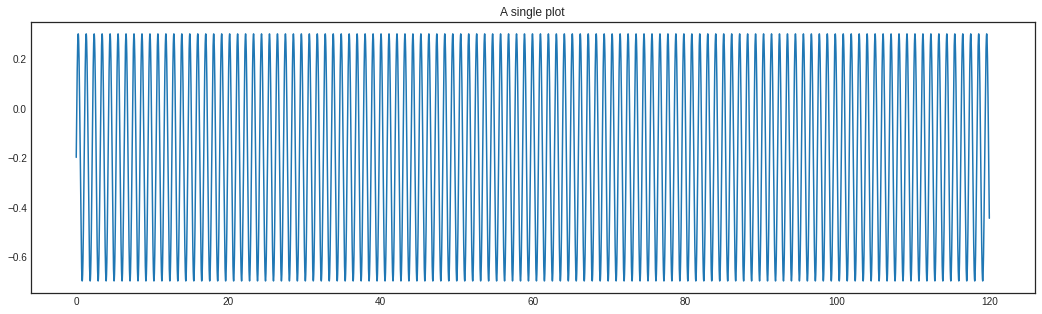

In [5]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

# Training 

In [10]:
st_Traj = 0
en_Traj = 4000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [11]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train_theta = torch.from_numpy(Y_train_theta).float()
Y_train_x = torch.from_numpy(Y_train_x).float()
X_prior = torch.from_numpy(X_prior).float()

# Putting tensors on GPU
X_train = X_train.cuda()
Y_train_theta = Y_train_theta.cuda()
Y_train_x = Y_train_x.cuda()
X_prior = X_prior.cuda()

# GPyTorch

In [12]:
kernel = gp.kernels.RBF(input_dim=4, variance=torch.tensor(5.0), lengthscale=torch.tensor(5))

kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.5), torch.tensor(10)))

gpr_th = gp.models.GPRegression(X_train, Y_train_theta, kernel, noise=torch.tensor(1.0))
gpr_x = gp.models.GPRegression(X_train, Y_train_x, kernel, noise=torch.tensor(1.0))

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyro/contrib/gp/parameterized.py:109: UserWarning: The method `self.set_prior(variance, prior)` has been deprecated in favor of `self.variance = PyroSample(prior)`.
  UserWarning,
/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyro/contrib/gp/parameterized.py:109: UserWarning: The method `self.set_prior(lengthscale, prior)` has been deprecated in favor of `self.lengthscale = PyroSample(prior)`.
  UserWarning,


In [15]:
gpr_th.cuda()

#guide = pyro.infer.autoguide.guides.AutoGuide(gpr_th)
# note that our priors have support on the positive reals
#gpr_th.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
#gpr_th.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

pyro.clear_param_store()
optimizer = torch.optim.Adam(gpr_th.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr_th.kernel.variance.item())
    noises.append(gpr_th.noise.item())
    lengthscales.append(gpr_th.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr_th.model, gpr_th.guide)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, i, loss.item(),
        gpr_th.noise.item()
    ))
    optimizer.step()
    losses.append(loss.item())

/home/belal/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'kernel.lengthscale', 'kernel.variance'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Iter 1/0 - Loss: 5528.648  noise: 1.000
Iter 2/1 - Loss: 5558.865  noise: 0.990
Iter 3/2 - Loss: 5460.884  noise: 0.981
Iter 4/3 - Loss: 5545.646  noise: 0.971
Iter 5/4 - Loss: 5543.530  noise: 0.962
Iter 6/5 - Loss: 5387.667  noise: 0.953
Iter 7/6 - Loss: 5549.460  noise: 0.945
Iter 8/7 - Loss: 5537.632  noise: 0.937
Iter 9/8 - Loss: 5297.250  noise: 0.929
Iter 10/9 - Loss: 5455.125  noise: 0.921
Iter 11/10 - Loss: 5305.596  noise: 0.913
Iter 12/11 - Loss: 5545.487  noise: 0.905
Iter 13/12 - Loss: 5544.527  noise: 0.898
Iter 14/13 - Loss: 5482.140  noise: 0.892
Iter 15/14 - Loss: 5348.770  noise: 0.887
Iter 16/15 - Loss: 5529.741  noise: 0.881
Iter 17/16 - Loss: 5417.735  noise: 0.876
Iter 18/17 - Loss: 5549.087  noise: 0.871
Iter 19/18 - Loss: 5494.458  noise: 0.867
Iter 20/19 - Loss: 5370.162  noise: 0.864
Iter 21/20 - Loss: 5557.689  noise: 0.860
Iter 22/21 - Loss: 5547.871  noise: 0.858
Iter 23/22 - Loss: 5565.422  noise: 0.857
Iter 24/23 - Loss: 4775.071  noise: 0.857
Iter 25/24 

In [70]:
gpr_x.cuda()

pyro.clear_param_store()
optimizer = torch.optim.Adam(gpr_x.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 500 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr_x.kernel.variance.item())
    noises.append(gpr_x.noise.item())
    lengthscales.append(gpr_x.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr_x.model, gpr_x.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [37]:
with torch.no_grad():
    mean_th, cov_th = gpr_th(X_prior, full_cov=True)    
with torch.no_grad():
    mean_x, cov_x = gpr_x(X_prior, full_cov=True) 

sd_th = cov_th.diag().sqrt() # standard deviation for each point 
sd_x = cov_x.diag().sqrt()

In [38]:
# Putting tensors on GPU
X_train = X_train.cpu()
Y_train_theta = Y_train_theta.cpu()
Y_train_x = Y_train_x.cpu()
X_prior = X_prior.cpu()

mean_th = mean_th.cpu()
mean_x = mean_x.cpu()
sd_th = sd_th.cpu()
sd_x = sd_x.cpu()

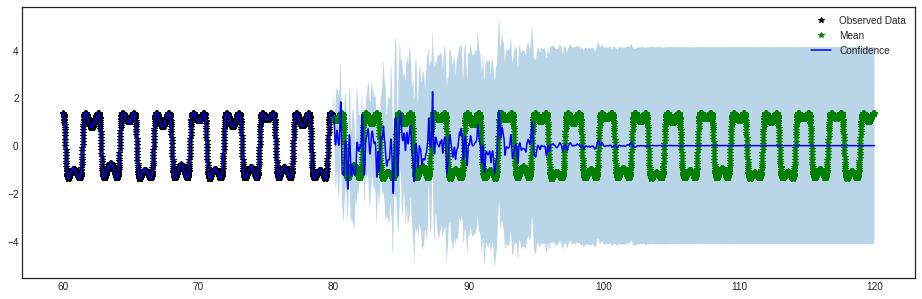

In [39]:
star_Traj = 6000
mids_Traj = 8000
ends_Traj = 12000

fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(16)

# Get upper and lower confidence bounds
ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_theta[star_Traj:], 'k*')
ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_theta[:ends_Traj-mids_Traj], 'g*')
ax.plot(timeSteps[star_Traj:ends_Traj], mean_th.numpy()[star_Traj:ends_Traj], 'b')

ax.fill_between(timeSteps[star_Traj:ends_Traj], (mean_th - 1.96*sd_th).numpy()[star_Traj:ends_Traj], (mean_th + 1.96*sd_th).numpy()[star_Traj:ends_Traj], alpha=0.3)
#ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

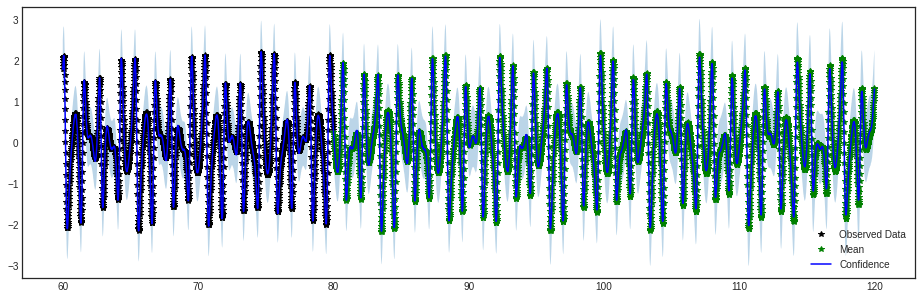

In [80]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1)

    fig.set_figheight(5)
    fig.set_figwidth(16)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_x.confidence_region()
    lower = lower.cpu()
    upper = upper.cpu()
    mean = observed_pred_x.mean
    mean = mean.cpu()
    ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_x[star_Traj:], 'k*')
    ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_x[:ends_Traj-mids_Traj], 'g*')
    ax.plot(timeSteps[star_Traj:ends_Traj], mean.numpy()[star_Traj:ends_Traj], 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(timeSteps[star_Traj:ends_Traj], lower.numpy()[star_Traj:ends_Traj], upper.numpy()[star_Traj:ends_Traj], alpha=0.3)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# RMSE

In [38]:
model_th.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/th_RatQuad_gpytorch'))
model_x.load_state_dict(torch.load('../../learnedModels/deterministicCase/GPwithGPyTorch/x_RatQuad_gpytorch'))

<All keys matched successfully>

In [39]:
trunc_st = 0
trunc_en = 9000

X_prior = np.stack(((theta_sim[trunc_st:trunc_en]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[trunc_st:trunc_en]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[trunc_st:trunc_en]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[trunc_st:trunc_en]-forceIn_mean)/forceIn_stdev), axis=1)
#X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

# Putting back on CPU
X_prior = torch.from_numpy(X_prior).float()
X_prior = X_prior.cuda()

In [40]:
mu_th_dd = np.zeros(X_prior.shape[0])
lower_th, upper_th = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_th_d = np.zeros(X_prior.shape[0])
gp_th = np.zeros(X_prior.shape[0])

mu_x_dd = np.zeros(X_prior.shape[0])
lower_x, upper_x = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_x_d = np.zeros(X_prior.shape[0])
gp_x = np.zeros(X_prior.shape[0])

mu_th_dd[0] =  theta_dd_sim[trunc_st]
gp_th_d[0] = theta_d_sim[trunc_st]
gp_th[0] = theta_sim[trunc_st]
mu_x_dd[0] = x_dd_sim[trunc_st]
gp_x_d[0] = x_d_sim[trunc_st]
gp_x[0] = x_sim[trunc_st]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        model_th.eval()
        model_x.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred_th = likelihood(model_th(X_prior[k,:].reshape(1,-1)))
            observed_pred_x = likelihood(model_x(X_prior[k,:].reshape(1,-1)))
            mu_th_dd[k+1] = observed_pred_th.mean
            mu_x_dd[k+1] = observed_pred_x.mean
            lower_th[k+1], upper_th[k+1] = observed_pred_th.confidence_region()
            lower_x[k+1], upper_x[k+1] = observed_pred_x.confidence_region()
        unstand_acc = mu_th_dd[k+1]*theta_dd_sim_stdev + theta_dd_sim_mean
        gp_th_d[k+1] = gp_th_d[k]+(unstand_acc)*(dt)
        #X_prior[k+1,1] = (gp_th_d[k+1]-theta_d_sim_mean) / theta_d_sim_stdev
        gp_th[k+1] = gp_th[k] + (gp_th_d[k+1] + gp_th_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        #X_prior[k+1,0] = (gp_th[k+1]-theta_sim_mean) / theta_sim_stdev
        unstand_x = mu_x_dd[k+1]*x_dd_sim_stdev + x_dd_sim_mean
        gp_x_d[k+1] = gp_x_d[k]+(unstand_x)*(dt)
        #X_prior[k+1,2] = (gp_x_d[k+1]-x_d_sim_mean) / x_d_sim_stdev
        gp_x[k+1] = gp_x[k] + (gp_x_d[k+1] + gp_x_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)

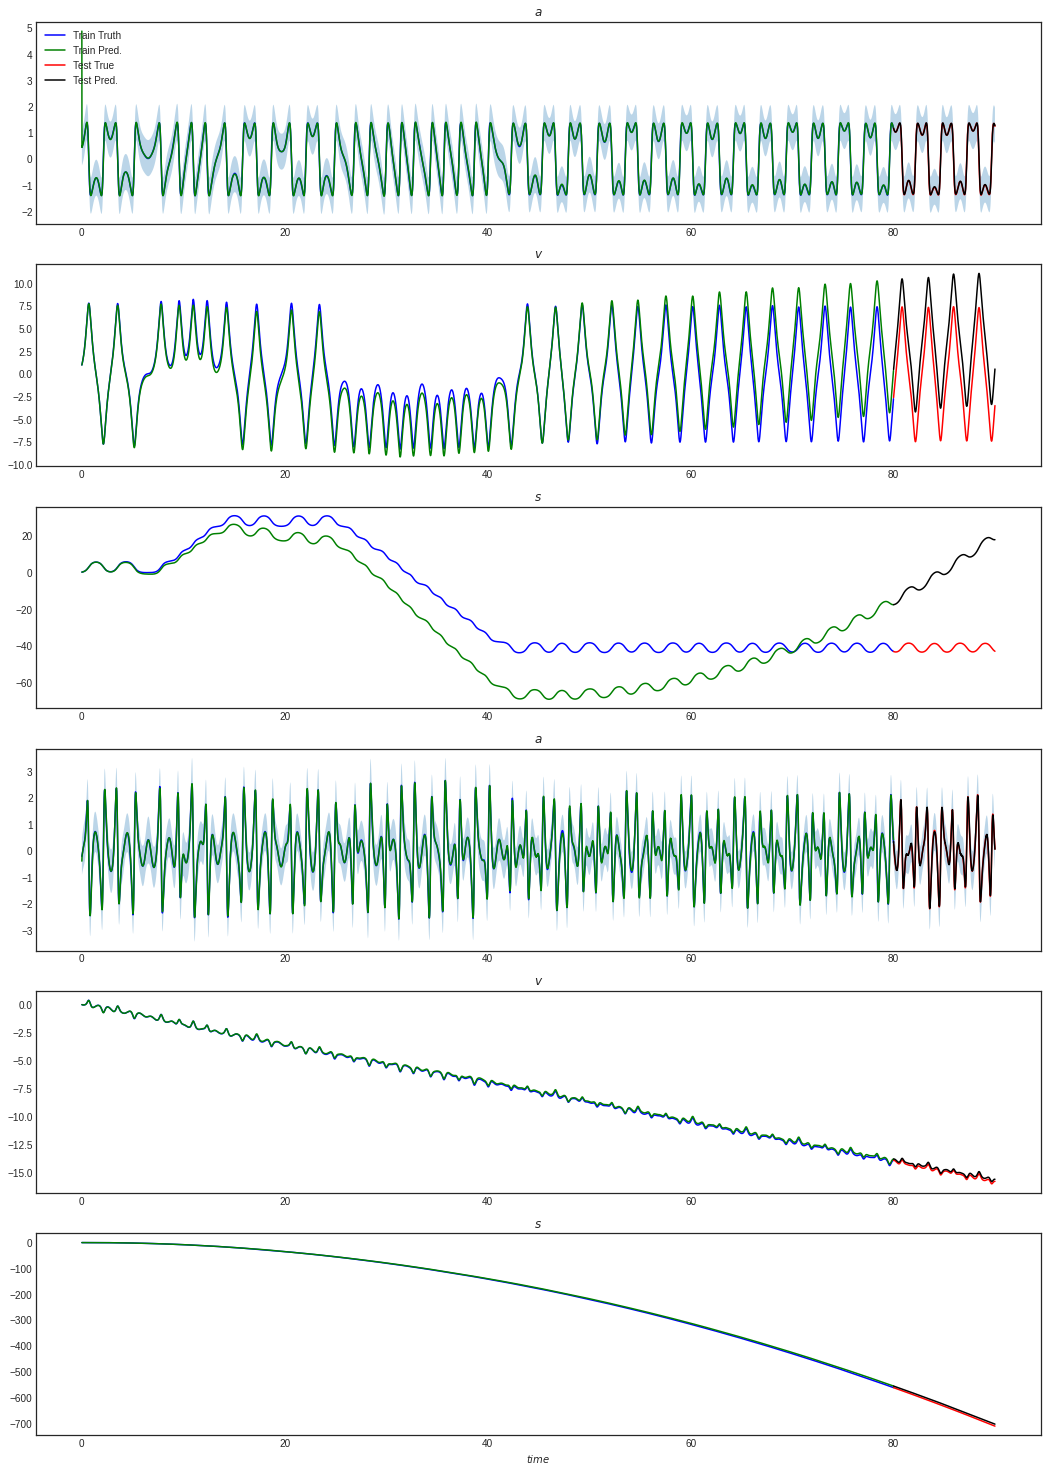

In [41]:
# Plotting 
train_test_split = 8000 # define it above later on 

st_Trajec = trunc_st
mid_Trajec = train_test_split
en_Trajec = trunc_en

# For predictions
mid_pred = train_test_split - trunc_st 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6) 

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.fill_between(timeSteps[st_Trajec:en_Trajec], lower_th, upper_th, alpha=0.3)
b1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_theta[st_Trajec:mid_Trajec], "b")
g1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], mu_th_dd[:mid_pred], "g")
r1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_theta[:en_Trajec-mid_Trajec], "r")
k1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], mu_th_dd[mid_pred:], "k")
ax1.set_title('$a$')

ax2.plot(timeSteps[st_Trajec:mid_Trajec], theta_d_sim[st_Trajec:mid_Trajec], "b")
ax2.plot(timeSteps[st_Trajec:mid_Trajec], gp_th_d[:mid_pred], "g")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], theta_d_sim[mid_Trajec:en_Trajec], "r")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], gp_th_d[mid_pred:], "k")
ax2.set_title('$v$')

ax3.plot(timeSteps[st_Trajec:mid_Trajec], theta_sim[st_Trajec:mid_Trajec], "b")
ax3.plot(timeSteps[st_Trajec:mid_Trajec], gp_th[:mid_pred], "g")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], theta_sim[mid_Trajec:en_Trajec], "r")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], gp_th[mid_pred:], "k")
ax3.set_title('$s$')

ax4.fill_between(timeSteps[st_Trajec:en_Trajec], lower_x, upper_x, alpha=0.3)
ax4.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_x[st_Trajec:], "b")
ax4.plot(timeSteps[st_Trajec:mid_Trajec], mu_x_dd[:mid_pred], "g")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_x[:en_Trajec-mid_Trajec], "r")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], mu_x_dd[mid_pred:], "k")
ax4.set_title('$a$')

ax5.plot(timeSteps[st_Trajec:mid_Trajec], x_d_sim[st_Trajec:mid_Trajec], "b")
ax5.plot(timeSteps[st_Trajec:mid_Trajec], gp_x_d[:mid_pred], "g")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], x_d_sim[mid_Trajec:en_Trajec], "r")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], gp_x_d[mid_pred:], "k")
ax5.set_title('$v$')

ax6.plot(timeSteps[st_Trajec:mid_Trajec], x_sim[st_Trajec:mid_Trajec], "b")
ax6.plot(timeSteps[st_Trajec:mid_Trajec], gp_x[:mid_pred], "g")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], x_sim[mid_Trajec:en_Trajec], "r")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], gp_x[mid_pred:], "k")
ax6.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('GP_Exp_Stand_JIANG(A).png')
plt.show()